In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import os

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

In [4]:
filename = "mdom_ibd_0_20m_1E5.dat"
dir = "~/software/doumeki/bulkice_doumeki/analysis/files/output_geant4/signal/mDOM/"
path = os.path.join(dir, filename)

df = pd.read_csv(path, delimiter="\t", header = None)
df.columns = ["event_id", "time", "energy", "pmt_id", "hit_pos_x", "hit_pos_y", "hit_pos_z", 
              "ver_pos_x", "ver_pos_y", "ver_pos_z", "?", "survival", "?"]

df

mask = df["survival"] == 1
ver_radius = np.sqrt(df["ver_pos_x"]**2 + df["ver_pos_y"]**2 + df["ver_pos_z"]**2)


In [5]:
df

data = df

# calculates coincidence rates, time differences, etc.

time_window = 20 # ns
unique_event = np.unique(data.iloc[:,0]) # unique events

time_diff_pmt = [[] for _ in range(24)] # time difference between first and last element depending on how many PMTs recorded hits in an event
time_event = [] # normalized time sequence for each event
count_pmt = np.zeros(24) # number of counts/hits per PMT

for j, ue in enumerate(unique_event): # loop over all unique event IDs
    mask_event = (data.iloc[:,0] == ue).values # mask for entries from the same event

    time = data.iloc[:,1][mask_event].values # all times of a given event
    pmts = data.iloc[:,3][mask_event].values # all PMTstime of a given event
    unique_pmt = np.unique(pmts) # unique PMTs

    time_sorted = np.sort(time) # sort event times
    time_normed = time_sorted - time_sorted[0] # normalized time to first entry

    mask_time = time_normed <= time_window # mask time with time window
    time_masked = time_normed[mask_time]

    if len(time_masked) > 1: # if there is more than one entry
        
        time_diff = time_masked[-1] - time_masked[0] # time difference between first element (=0) and last element
        
        time_event.append(time_masked) # save in list
        
        for i in range(len(unique_pmt)): # loop over number of unique PMTs = coincidence
            time_diff_pmt[i].append(time_diff)

    for i in range(len(unique_pmt)): # loop over number of unique PMTs = coincidence
        count_pmt[i] += len(time_masked)

time_event = np.array(time_event, dtype=object) # transform into array
time_diff_pmt = np.array(time_diff_pmt, dtype=object)

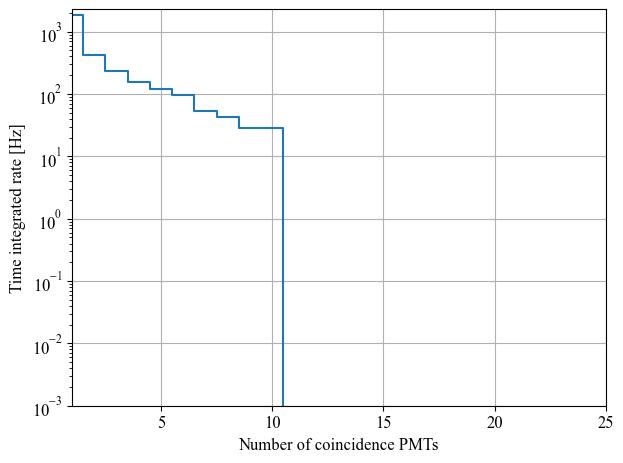

In [38]:
time_window = (data.iloc[:,1].max()-data.iloc[:,1].min())/1E9 # in s
coincidence_rate = count_pmt/time_window
normalized_rate = coincidence_rate/coincidence_rate[0]

fig, ax = plt.subplots(1,1)
ax.step(np.arange(1,25), coincidence_rate, where = "mid")
ax.set_xlim(1,25)
ax.set_yscale("log")
ax.set_yticks([1E3,1E2,1E1,1,1E-1,1E-2,1E-3])
ax.set_xlabel("Number of coincidence PMTs")
ax.set_ylabel("Time integrated rate [Hz]")
ax.grid()
plt.tight_layout()


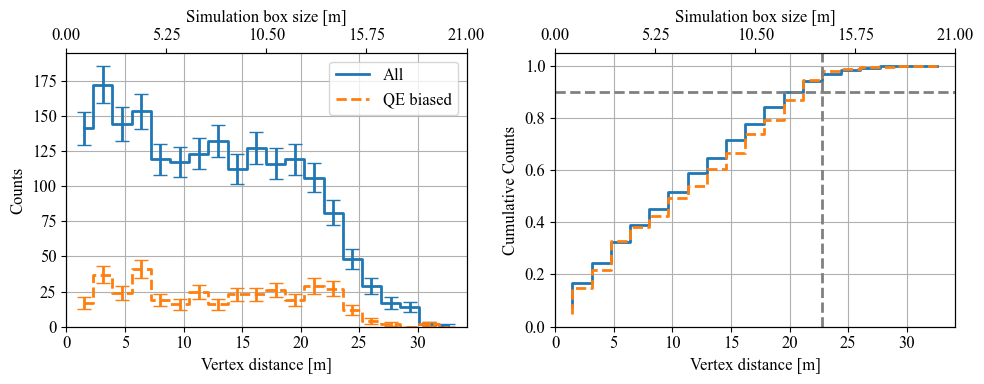

In [6]:
bins = 20
xrange = (np.min(ver_radius), np.max(ver_radius))

y, edges = np.histogram(ver_radius, bins=bins, range=xrange)
y_masked, edges = np.histogram(ver_radius[mask], bins=bins, range=xrange)

x = (edges[1:]+edges[:-1])/2


cum_y = np.cumsum(y)/np.sum(y)
cum_y_masked = np.cumsum(y_masked)/np.sum(y_masked)

cum_thresh = 0.9

idx = np.argmin(np.where(cum_y > cum_thresh, cum_y, np.inf))
idx_masked = np.argmin(np.where(cum_y_masked > cum_thresh, cum_y_masked, np.inf))

fig, ax = plt.subplots(1,2, figsize = (10,4))

ax[0].step(x, y, where = "mid", lw = 2, color = "C0", label="All")
ax[0].errorbar(x, y, yerr = np.sqrt(y), ls = "", lw = 2, color = "C0", capsize = 5)
ax[0].step(x, y_masked, where = "mid", lw = 2, ls = "--", color = "C1", label="QE biased")
ax[0].errorbar(x, y_masked, yerr = np.sqrt(y_masked), ls = "", lw = 2, color = "C1", capsize = 5)
ax[0].set_xlabel(r"Vertex distance [m]")
ax[0].set_ylabel("Counts")
ax[0].set_xlim(0,)
ax[0].set_ylim(0,)
ax[0].grid()
ax[0].legend()

# Add a second x-axis
ax0_top = ax[0].twiny()  # Twin x-axis on the bottom subplot
ax0_top.set_xlabel("Simulation box size [m]")  # Label for second x-axis

# Adjust the second x-axis ticks to be 1/sqrt(3) of the first x-axis
factor = 1 / np.sqrt(3)
x_min, x_max = ax[0].get_xlim()
trans_min, trans_max = x_min * factor, x_max * factor

# Set whole number ticks on the upper axis
upper_ticks = np.linspace(np.round(trans_min,0), np.round(trans_max,0) + 1, 5, endpoint=True)  # Whole numbers
ax0_top.set_xticks(upper_ticks)


ax[1].step(x, cum_y, lw = 2, label="All")
ax[1].step(x, cum_y_masked, lw = 2, ls = "--", label="QE biased")
ax[1].axhline(cum_thresh, color="grey", ls = "--", lw = 2)

if idx != idx_masked:
    ax[1].axvline(x[idx], color="C0", ls = "--", lw = 2)
    ax[1].axvline(x[idx_masked], color="C1", ls = "--", lw = 2)
else:
    ax[1].axvline(x[idx], color="grey", ls = "--", lw = 2)


ax[1].set_xlabel(r"Vertex distance [m]")
ax[1].set_ylabel("Cumulative Counts")
ax[1].set_xlim(0,)
ax[1].grid()


ax1_top = ax[1].twiny()  # Twin x-axis on the bottom subplot
ax1_top.set_xlabel("Simulation box size [m]")  # Label for second x-axis
ax1_top.set_xticks(upper_ticks)


plt.tight_layout()

/tmp/ipykernel_64949/402290267.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


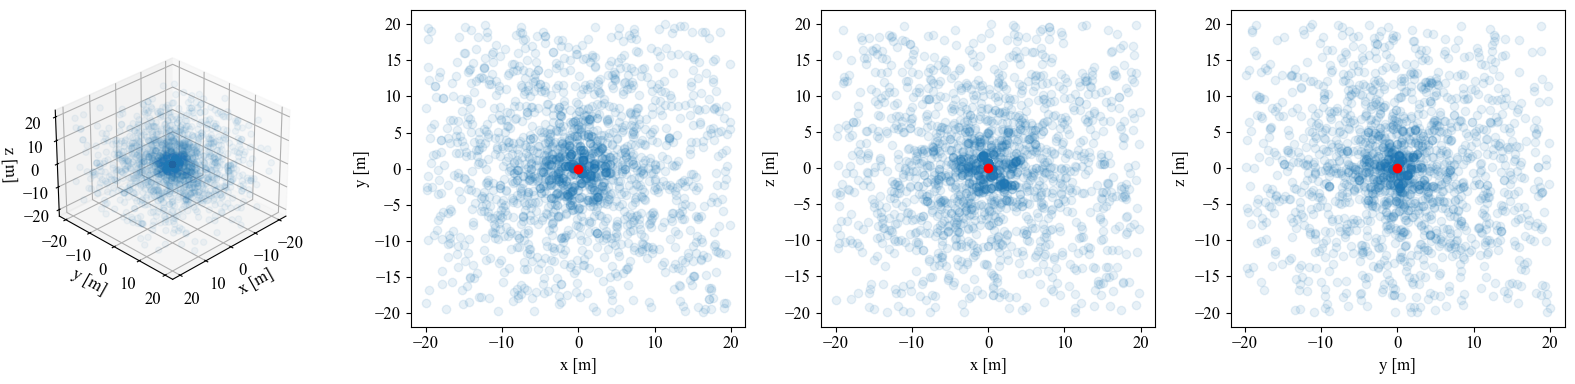

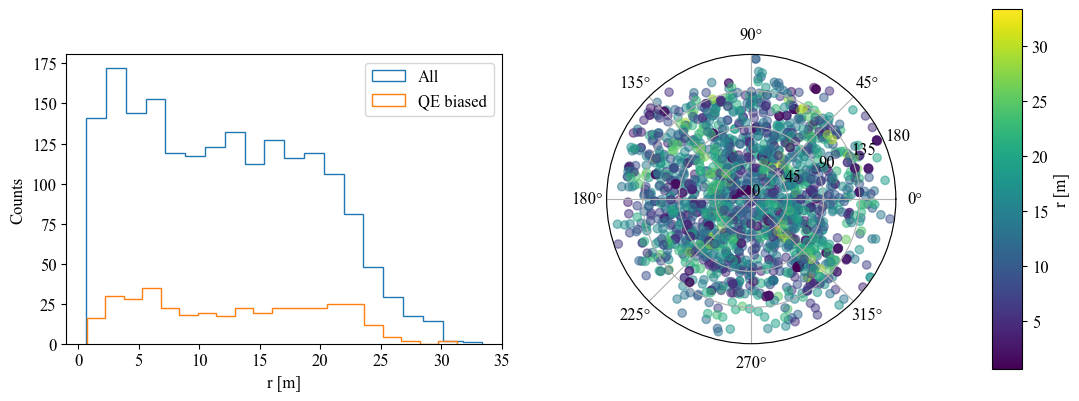

In [30]:
# plot vertex position in cartesian coordinates and spherical coordinates

data = df

x = data.iloc[:,7]
y = data.iloc[:,8]
z = data.iloc[:,9]

r = np.sqrt(x**2 + y**2 + z**2) # vertex radial distance
phi = np.arctan2(y, x) # vertex azimuth
theta = np.arccos(z/r) # vertex zenith

mask = data.iloc[:,-2] == 1

fig = plt.figure(figsize = (16,4))

ax1 = fig.add_subplot(1,4,1, projection='3d')
ax1.scatter(x,y,z, alpha = 0.05)
ax1.scatter(0,0,0, color = "red")
ax1.view_init(elev=30., azim=45)
ax1.set_xlabel("x [m]")
ax1.set_ylabel("y [m]")
ax1.set_zlabel("z [m]")
ax1.set_box_aspect(None, zoom=0.8)

ax2 = fig.add_subplot(1,4,2)
ax2.scatter(x,y, alpha = 0.1)
ax2.scatter(0,0, color = "red", zorder = 10)
ax2.set_xlabel("x [m]")
ax2.set_ylabel("y [m]")

ax3 = fig.add_subplot(1,4,3)
ax3.scatter(x,z, alpha = 0.1)
ax3.scatter(0,0, color = "red", zorder = 10)
ax3.set_xlabel("x [m]")
ax3.set_ylabel("z [m]")

ax4 = fig.add_subplot(1,4,4)
ax4.scatter(y,z, alpha = 0.1)
ax4.scatter(0,0, color = "red", zorder = 10)
ax4.set_xlabel("y [m]")
ax4.set_ylabel("z [m]")
plt.tight_layout()


fig = plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(1,2,1)
ax1.hist(r, bins = 20, histtype = "step", label="All")
ax1.hist(r[mask], bins = 20, histtype = "step", label="QE biased")
ax1.set_xlabel("r [m]")
ax1.set_ylabel("Counts")
ax1.legend()

ax2 = fig.add_subplot(1,2,2, polar = True)
sc = ax2.scatter(phi, np.rad2deg(theta), c=r, alpha = 0.5)
ax2.set_ylim(0,180)
ax2.set_yticks([0,45,90,135,180])
#ax2.set_xlabel(r"$\phi$")
#ax2.set_ylabel(r"$\theta$")

cax = fig.add_axes([1,0.1,0.03,0.9])
cbar = fig.colorbar(sc, cax=cax, label="r [m]")#, ticks=[0,10,20,30])
cbar.solids.set(alpha = 1)
plt.tight_layout()

In [172]:
gun_radius = np.array([1,2,5,10,20,50])
gun_volume = 4/3 * np.pi * gun_radius**3

num_positrons = 1000

num_photons = []
num_photons_qe_biased = []

for rad in gun_radius:

    filename = "mdom_ibd_0_{:.0f}m.dat".format(rad)
    dir = "~/software/doumeki/bulkice_doumeki/analysis/files/output_geant4/signal/mDOM/"
    path = os.path.join(dir, filename)

    df = pd.read_csv(path, delimiter="\t", header = None)
    df.columns = ["event_id", "time", "energy", "pmt_id", "hit_pos_x", "hit_pos_y", "hit_pos_z", 
                "ver_pos_x", "ver_pos_y", "ver_pos_z", "?", "survival", "?"]

    num_photons.append(df.size)
    num_photons_qe_biased.append((df["survival"]==1).sum())

num_photons = np.array(num_photons)
num_photons_qe_biased = np.array(num_photons_qe_biased)

gun_effvol_ph = gun_volume * num_photons/num_positrons
gun_effvol_ph_qe_biased = gun_volume * num_photons_qe_biased/num_positrons


gun_effrad_ph = 3/(4*np.pi) * (gun_effvol_ph)**(1/3) 
gun_effrad_ph_qe_biased = 3/(4*np.pi) * (gun_effvol_ph_qe_biased)**(1/3) 

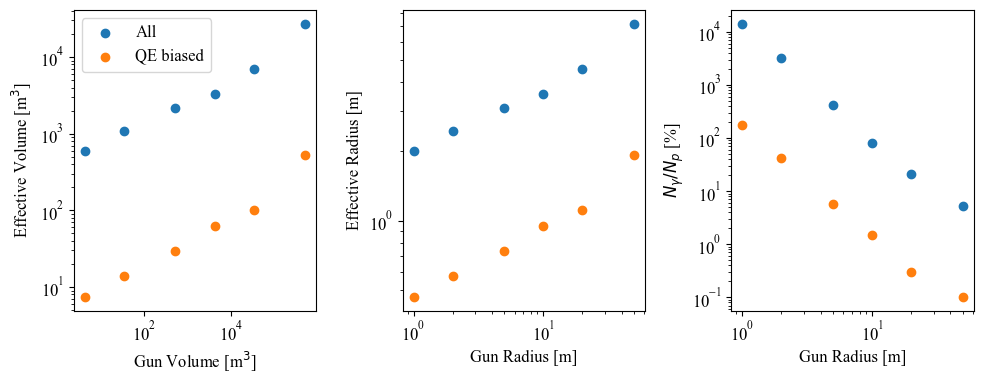

In [173]:
fig, ax = plt.subplots(1,3, figsize = (10,4))

ax[0].scatter(gun_volume, gun_effvol_ph, label = "All")
ax[0].scatter(gun_volume, gun_effvol_ph_qe_biased, label="QE biased")
ax[0].set_xlabel(r"Gun Volume [m$^3$]")
ax[0].set_ylabel(r"Effective Volume [m$^3$]")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].legend()

ax[1].scatter(gun_radius, gun_effrad_ph, label = "All")
ax[1].scatter(gun_radius, gun_effrad_ph_qe_biased, label="QE biased")
ax[1].set_xlabel(r"Gun Radius [m]")
ax[1].set_ylabel(r"Effective Radius [m]")
ax[1].set_xscale("log")
ax[1].set_yscale("log")

ax[2].scatter(gun_radius, num_photons/num_positrons * 100, label = "All")
ax[2].scatter(gun_radius, num_photons_qe_biased/num_positrons * 100, label="QE biased")
ax[2].set_xlabel(r"Gun Radius [m]")
ax[2].set_ylabel(r"$N_{\gamma} / N_p$ [%]")
ax[2].set_xscale("log")
ax[2].set_yscale("log")

plt.tight_layout()

In [ ]:
# simulate to big of a volume
# plot cumulative distribution and check quantiles
# 